In [22]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets,layers,models
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [23]:
import os

# Update the imgag variable with the correct path
imgag = r"C:\Users\prath\Downloads\Brain\BDT\BTDS"

# Check if the specified path exists
if os.path.exists(imgag):
    print("The specified path exists.")
else:
    print("The specified path does not exist.")

# Print information about each subfolder and its images
for expression in os.listdir(imgag):
    if not expression.startswith('.'):  # Filter out hidden files (optional)
        num_images = len(os.listdir(os.path.join(imgag, expression)))
        print(expression, "folder contains\t\t", num_images, 'images')


The specified path exists.
Brain Tumor folder contains		 2513 images
Healthy folder contains		 2087 images


In [24]:
BATCH_SIZE = 64
IMAGE_SIZE = 150
input_shape = (150,150,3)

In [25]:
Data_gen = ImageDataGenerator(rescale = 1.0/255,validation_split = 0.2)

In [26]:
train_set = Data_gen.flow_from_directory(imgag,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size = BATCH_SIZE,
                                        color_mode= "rgb",
                                        shuffle=True,
                                        class_mode = "binary",
                                        subset = "training")

Found 3681 images belonging to 2 classes.


In [27]:
test_set = Data_gen.flow_from_directory(imgag,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size = BATCH_SIZE,
                                        color_mode= "rgb",
                                        shuffle=False,
                                        class_mode = "binary",
                                        subset = "validation")

Found 919 images belonging to 2 classes.


In [28]:
train_labels = train_set.classes
test_labels = test_set.classes


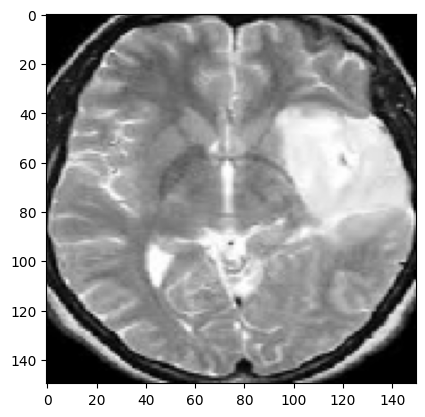

In [29]:
batch = next(train_set)

plt.imshow(batch[0][0])

In [1]:
from keras.applications import NASNetMobile
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout
nas_model = Sequential()
model = NASNetMobile(weights='imagenet',
                    include_top = False,
                    input_shape = (150,150,3))
for layer in model.layers:
    layer.trainable=False
nas_model.add(model)
nas_model.add(Flatten())
nas_model.add(Dense(512,activation='relu'))

nas_model.add(Dense(256,activation='relu'))

nas_model.add(Dense(128,activation='relu'))

nas_model.add(Dense(1,activation='sigmoid'))
nas_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 5, 5, 1056)        4269716   
                                                                 
 flatten (Flatten)           (None, 26400)             0         
                                                                 
 dense (Dense)               (None, 512)               13517312  
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 70)                9030      
                                                                 
Total params: 17960282 (68.51 MB)
Trainable params: 1369

In [31]:
optimizer = tf.keras.optimizers.Adam()
nas_model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])

In [84]:
epochs = 10
history = nas_model.fit(
    train_set,
    validation_data=test_set,
    epochs=epochs
)

Epoch 1/10
58/58 [==============================] - 288s 4s/step - loss: 0.6607 - accuracy: 0.8009 - val_loss: 0.2037 - val_accuracy: 0.9184
Epoch 2/10
58/58 [==============================] - 486s 8s/step - loss: 0.1716 - accuracy: 0.9340 - val_loss: 0.1137 - val_accuracy: 0.9532
Epoch 3/10
58/58 [==============================] - 439s 7s/step - loss: 0.0778 - accuracy: 0.9720 - val_loss: 0.0944 - val_accuracy: 0.9652
Epoch 4/10
58/58 [==============================] - 220s 4s/step - loss: 0.0420 - accuracy: 0.9870 - val_loss: 0.0407 - val_accuracy: 0.9848
Epoch 5/10
58/58 [==============================] - 219s 4s/step - loss: 0.0151 - accuracy: 0.9959 - val_loss: 0.0556 - val_accuracy: 0.9815
Epoch 6/10
58/58 [==============================] - 215s 4s/step - loss: 0.0222 - accuracy: 0.9908 - val_loss: 0.0391 - val_accuracy: 0.9891
Epoch 7/10
58/58 [==============================] - 210s 4s/step - loss: 0.0270 - accuracy: 0.9908 - val_loss: 0.0637 - val_accuracy: 0.9750
Epoch 8/10
58

In [85]:
train_loss, train_acc = nas_model.evaluate(train_set)
test_loss, test_acc   = nas_model.evaluate(test_set)
test_loss, test_acc

15/15 [==============================] - 54s 4s/step - loss: 0.0504 - accuracy: 0.9837


(0.05039609596133232, 0.9836779236793518)

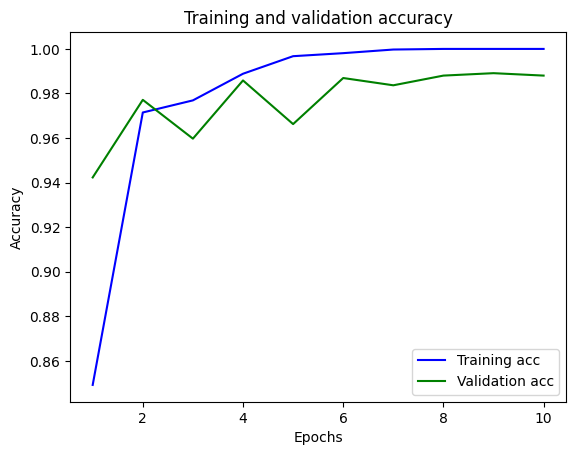

In [21]:
import matplotlib.pyplot as plt


# Get the accuracy and validation accuracy from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Get the number of epochs used for training
epochs = range(1, len(acc) + 1)

# Plot the training and validation accuracy
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


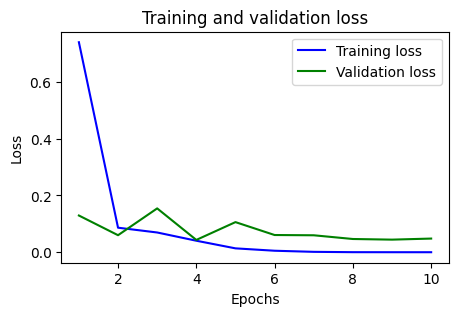

In [22]:
plt.figure(figsize=(5, 3))
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [12]:
import tensorflow as tf
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications import NASNetMobile
def build_nasnet_model(hp):
    model = Sequential()
    n_model = NASNetMobile(weights='imagenet',
                    include_top = False,
                    input_shape = (150,150,3))
    for layer in n_model.layers:
        layer.trainable=False
    model.add(n_model)
    model.add(Flatten())
    model.add(Dense(units=hp.Int('dense_units_1', min_value=128, max_value=1024, step=128, default=512), activation=hp.Choice('activation_1', values=['relu', 'tanh', 'sigmoid'])))
    model.add(Dense(units=hp.Int('dense_units_2', min_value=64, max_value=512, step=64, default=256), activation=hp.Choice('activation_2', values=['relu', 'tanh', 'sigmoid'])))
    model.add(Dense(units=hp.Int('dense_units_3', min_value=32, max_value=256, step=32, default=128), activation=hp.Choice('activation_3', values=['relu', 'tanh', 'sigmoid'])))
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-3)
    
    if optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [13]:
#initialize the tuner
tuner = RandomSearch(
        build_nasnet_model,
        objective='val_accuracy',
        max_trials=5,
        directory='tuner_directory',
        project_name='nasnet_tuner'
)


INFO:tensorflow:Reloading Tuner from tuner_directory\nasnet_tuner\tuner0.json


In [14]:
tuner.search(train_set, epochs=5, validation_data=test_set)

Trial 5 Complete [00h 40m 25s]
val_accuracy: 0.9858542084693909

Best val_accuracy So Far: 0.9880304932594299
Total elapsed time: 00h 40m 25s
INFO:tensorflow:Oracle triggered exit


In [15]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [18]:
best_model = build_nasnet_model(best_hps)

In [19]:
best_model.compile(optimizer=best_hps.get('optimizer'), loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
best_model.fit(train_set, validation_data=test_set, epochs=10)

Epoch 1/10
58/58 [==============================] - 609s 8s/step - loss: 0.4506 - accuracy: 0.7995 - val_loss: 0.3722 - val_accuracy: 0.8749
Epoch 2/10
58/58 [==============================] - 348s 6s/step - loss: 0.3612 - accuracy: 0.8522 - val_loss: 0.3497 - val_accuracy: 0.8542
Epoch 3/10
58/58 [==============================] - 358s 6s/step - loss: 0.2932 - accuracy: 0.8897 - val_loss: 0.2743 - val_accuracy: 0.9086
Epoch 4/10
58/58 [==============================] - 353s 6s/step - loss: 0.2365 - accuracy: 0.9087 - val_loss: 0.2321 - val_accuracy: 0.9162
Epoch 5/10
58/58 [==============================] - 354s 6s/step - loss: 0.2213 - accuracy: 0.9193 - val_loss: 0.3828 - val_accuracy: 0.8520
Epoch 6/10
58/58 [==============================] - 330s 6s/step - loss: 0.2543 - accuracy: 0.8981 - val_loss: 0.2054 - val_accuracy: 0.9282
Epoch 7/10
58/58 [==============================] - 367s 6s/step - loss: 0.2257 - accuracy: 0.9177 - val_loss: 0.2166 - val_accuracy: 0.9293
Epoch 8/10
58

In [32]:
#initialize the tuner
from keras_tuner.tuners import BayesianOptimization
Bn_tuner = BayesianOptimization(
        build_nasnet_model,
        objective='val_accuracy',
        max_trials=5,
        num_initial_points=2,
        directory='tuner_directory',
        project_name='bo_nasnet_tuner'
)


In [33]:
Bn_tuner.search(train_set, epochs=5, validation_data=test_set)

Trial 5 Complete [00h 29m 19s]
val_accuracy: 0.9129488468170166

Best val_accuracy So Far: 0.9303590655326843
Total elapsed time: 21h 00m 46s
INFO:tensorflow:Oracle triggered exit


In [35]:
best_hps_1 = Bn_tuner.get_best_hyperparameters(num_trials=1)[0]

In [36]:
best_model_1 = build_nasnet_model(best_hps_1)

In [37]:
best_model_1.compile(optimizer=best_hps_1.get('optimizer'), loss='binary_crossentropy', metrics=['accuracy'])

In [51]:
best_model_1.fit(train_set, validation_data=test_set, epochs=10)

Epoch 1/10
58/58 [==============================] - 366s 6s/step - loss: 0.6017 - accuracy: 0.7876 - val_loss: 0.4253 - val_accuracy: 0.8335
Epoch 2/10
58/58 [==============================] - 393s 7s/step - loss: 0.3690 - accuracy: 0.8354 - val_loss: 0.2450 - val_accuracy: 0.9064
Epoch 3/10
58/58 [==============================] - 390s 7s/step - loss: 0.2930 - accuracy: 0.8829 - val_loss: 0.2115 - val_accuracy: 0.9217
Epoch 4/10
58/58 [==============================] - 388s 7s/step - loss: 0.2133 - accuracy: 0.9049 - val_loss: 0.3099 - val_accuracy: 0.8346
Epoch 5/10
58/58 [==============================] - 375s 6s/step - loss: 0.2190 - accuracy: 0.9082 - val_loss: 0.5033 - val_accuracy: 0.8020
Epoch 6/10
58/58 [==============================] - 280s 5s/step - loss: 0.1793 - accuracy: 0.9258 - val_loss: 0.1052 - val_accuracy: 0.9597
Epoch 7/10
58/58 [==============================] - 318s 5s/step - loss: 0.1558 - accuracy: 0.9419 - val_loss: 0.0904 - val_accuracy: 0.9674
Epoch 8/10
58

In [40]:
Bn_tuner.results_summary()

Results summary
Results in tuner_directory\bo_nasnet_tuner
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 1 summary
Hyperparameters:
dense_units_1: 1024
activation_1: relu
dense_units_2: 64
activation_2: relu
dense_units_3: 128
activation_3: relu
optimizer: rmsprop
learning_rate: 0.0007775578967089125
Score: 0.9303590655326843

Trial 4 summary
Hyperparameters:
dense_units_1: 384
activation_1: tanh
dense_units_2: 512
activation_2: sigmoid
dense_units_3: 160
activation_3: relu
optimizer: rmsprop
learning_rate: 0.0009271419840508765
Score: 0.9129488468170166

Trial 0 summary
Hyperparameters:
dense_units_1: 256
activation_1: sigmoid
dense_units_2: 64
activation_2: tanh
dense_units_3: 64
activation_3: relu
optimizer: adam
learning_rate: 0.0029262274467137263
Score: 0.9042437672615051

Trial 3 summary
Hyperparameters:
dense_units_1: 896
activation_1: tanh
dense_units_2: 64
activation_2: sigmoid
dense_units_3: 160
activation_3: relu
optimizer: adam
learning_rate

In [52]:
train_loss, train_acc = best_model.evaluate(train_set)
test_loss, test_acc   = best_model.evaluate(test_set)
test_loss, test_acc

15/15 [==============================] - 72s 5s/step - loss: 0.2102 - accuracy: 0.9064


(0.2101564109325409, 0.9064199924468994)

AttributeError: 'HyperParameters' object has no attribute 'show'

In [62]:
from keras_tuner.tuners import Hyperband

H_tuner = Hyperband(
    build_nasnet_model,
    objective='val_accuracy',
    max_epochs=10,  # Maximum number of epochs for each configuration
    factor=3,  # Reduction factor for the number of trials in each bracket
    directory='tuner1_directory',
    project_name='hyperband_nasnet_tuner'
)

H_tuner.search(train_set, epochs=5, validation_data=test_set)

Trial 6 Complete [00h 17m 19s]
val_accuracy: 0.7301414608955383

Best val_accuracy So Far: 0.9434167742729187
Total elapsed time: 01h 34m 28s

Search: Running Trial #7

Value             |Best Value So Far |Hyperparameter
128               |896               |dense_units_1
sigmoid           |sigmoid           |activation_1
448               |512               |dense_units_2
tanh              |sigmoid           |activation_2
32                |160               |dense_units_3
sigmoid           |sigmoid           |activation_3
sgd               |adam              |optimizer
0.0023096         |0.0001281         |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
47/58 [=======================>......] - ETA: 47s - loss: 0.7029 - accuracy: 0.5482


KeyboardInterrupt



In [63]:
H_tuner.results_summary()

Results summary
Results in tuner1_directory\hyperband_nasnet_tuner
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0003 summary
Hyperparameters:
dense_units_1: 896
activation_1: sigmoid
dense_units_2: 512
activation_2: sigmoid
dense_units_3: 160
activation_3: sigmoid
optimizer: adam
learning_rate: 0.000128104407624946
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.9434167742729187

Trial 0001 summary
Hyperparameters:
dense_units_1: 896
activation_1: sigmoid
dense_units_2: 320
activation_2: relu
dense_units_3: 224
activation_3: tanh
optimizer: adam
learning_rate: 0.00025680189659437386
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.9412404894828796

Trial 0000 summary
Hyperparameters:
dense_units_1: 1024
activation_1: tanh
dense_units_2: 128
activation_2: tanh
dense_units_3: 128
activation_3: sigmoid
optimizer: adam
learning_rate: 0.0032782021543128572
tuner/epochs: 2
tuner/initial_epoch: 0
t

In [64]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
nasnet_model_H2 = Sequential()
model = tf.keras.applications.ResNet50(include_top=False,
                    input_shape=(150,150,3),
                    pooling='max',classes=2,
                    weights='imagenet')
for layer in model.layers:
    layer.trainable=False
nasnet_model_H2.add(model)
nasnet_model_H2.add(Flatten())
nasnet_model_H2.add(Dense(896,activation='sigmoid'))
nasnet_model_H2.add(Dense(512,activation='sigmoid'))
nasnet_model_H2.add(Dense(160,activation='sigmoid'))
nasnet_model_H2.add(Dense(1,activation='sigmoid'))

In [65]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.000128)
nasnet_model_H2.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])

In [66]:
epochs = 10
history_2 = nasnet_model_H2.fit(
    train_set,
    validation_data=test_set,
    epochs=epochs
)

Epoch 1/10
58/58 [==============================] - 931s 15s/step - loss: 0.6815 - accuracy: 0.5713 - val_loss: 0.6670 - val_accuracy: 0.6202
Epoch 2/10
58/58 [==============================] - 766s 13s/step - loss: 0.6199 - accuracy: 0.6830 - val_loss: 0.6124 - val_accuracy: 0.6551
Epoch 3/10
58/58 [==============================] - 848s 15s/step - loss: 0.5691 - accuracy: 0.7229 - val_loss: 0.6051 - val_accuracy: 0.6823
Epoch 4/10
58/58 [==============================] - 3129s 55s/step - loss: 0.5459 - accuracy: 0.7351 - val_loss: 0.5938 - val_accuracy: 0.7051
Epoch 5/10
58/58 [==============================] - 857s 15s/step - loss: 0.5294 - accuracy: 0.7427 - val_loss: 0.5571 - val_accuracy: 0.7095
Epoch 6/10
58/58 [==============================] - 857s 15s/step - loss: 0.5047 - accuracy: 0.7628 - val_loss: 0.5494 - val_accuracy: 0.7171
Epoch 7/10
58/58 [==============================] - 752s 13s/step - loss: 0.4766 - accuracy: 0.7783 - val_loss: 0.5567 - val_accuracy: 0.7356
Epoch

In [67]:
train_loss, train_acc = nasnet_model_H2.evaluate(train_set)
test_loss, test_acc   = nasnet_model_H2.evaluate(test_set)
test_loss, test_acc

15/15 [==============================] - 77s 5s/step - loss: 0.5013 - accuracy: 0.7661


(0.5013145804405212, 0.7660500407218933)

In [68]:
predictions =nasnet_model_H2.predict(test_set)
predicted_labels = (predictions > 0.5).astype(int)
from sklearn.metrics import f1_score
f1 = f1_score(test_labels, predicted_labels)
print(f1)

15/15 [==============================] - 53s 3s/step
0.7619047619047619


In [69]:
train_loss, train_acc = best_model_1.evaluate(train_set)
test_loss, test_acc   = best_model_1.evaluate(test_set)
test_loss, test_acc

15/15 [==============================] - 64s 4s/step - loss: 0.0630 - accuracy: 0.9717


(0.06300941854715347, 0.971708357334137)

In [70]:
predictions =best_model_1.predict(test_set)
predicted_labels = (predictions > 0.5).astype(int)
from sklearn.metrics import f1_score
f1 = f1_score(test_labels, predicted_labels)
print(f1)

15/15 [==============================] - 86s 4s/step
0.9689737470167065


In [71]:
predictions =best_model.predict(test_set)
predicted_labels = (predictions > 0.5).astype(int)
from sklearn.metrics import f1_score
f1 = f1_score(test_labels, predicted_labels)
print(f1)

15/15 [==============================] - 92s 4s/step
0.9029345372460497


In [72]:
predictions =nas_model.predict(test_set)
predicted_labels = (predictions > 0.5).astype(int)
from sklearn.metrics import f1_score
f1 = f1_score(test_labels, predicted_labels)
print(f1)

15/15 [==============================] - 93s 4s/step
0.4684210526315789


In [73]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
nasnet_model_H3 = Sequential()
model = tf.keras.applications.ResNet50(include_top=False,
                    input_shape=(150,150,3),
                    pooling='max',classes=2,
                    weights='imagenet')
for layer in model.layers:
    layer.trainable=False
nasnet_model_H3.add(model)
nasnet_model_H3.add(Flatten())
nasnet_model_H3.add(Dense(1024,activation='selu'))
nasnet_model_H3.add(Dense(512,activation='selu'))
nasnet_model_H3.add(Dense(128,activation='selu'))
nasnet_model_H3.add(Dense(1,activation='sigmoid'))

In [74]:
optimizer = tf.keras.optimizers.Adagrad()
nasnet_model_H3.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])

In [76]:
epochs = 10
history_1 = nasnet_model_H3.fit(
    train_set,
    validation_data=test_set,
    epochs=epochs
)

Epoch 1/10
58/58 [==============================] - 745s 13s/step - loss: 0.5973 - accuracy: 0.6936 - val_loss: 0.5738 - val_accuracy: 0.6899
Epoch 2/10
58/58 [==============================] - 614s 11s/step - loss: 0.5760 - accuracy: 0.7077 - val_loss: 0.6118 - val_accuracy: 0.6844
Epoch 3/10
58/58 [==============================] - 471s 8s/step - loss: 0.5469 - accuracy: 0.7224 - val_loss: 0.6741 - val_accuracy: 0.6061
Epoch 4/10
58/58 [==============================] - 594s 10s/step - loss: 0.5438 - accuracy: 0.7272 - val_loss: 0.5716 - val_accuracy: 0.7018
Epoch 5/10
58/58 [==============================] - 538s 9s/step - loss: 0.5582 - accuracy: 0.7118 - val_loss: 0.5616 - val_accuracy: 0.7029
Epoch 6/10
58/58 [==============================] - 582s 10s/step - loss: 0.5270 - accuracy: 0.7368 - val_loss: 0.5509 - val_accuracy: 0.7312
Epoch 7/10
58/58 [==============================] - 635s 11s/step - loss: 0.5138 - accuracy: 0.7547 - val_loss: 0.6139 - val_accuracy: 0.6670
Epoch 8/

In [77]:
train_loss, train_acc = nasnet_model_H3.evaluate(train_set)
test_loss, test_acc   = nasnet_model_H3.evaluate(test_set)
test_loss, test_acc

15/15 [==============================] - 102s 7s/step - loss: 0.5773 - accuracy: 0.6997


(0.5772911906242371, 0.6996735334396362)

In [78]:
predictions =nasnet_model_H3.predict(test_set)
predicted_labels = (predictions > 0.5).astype(int)
from sklearn.metrics import f1_score
f1 = f1_score(test_labels, predicted_labels)
print(f1)

15/15 [==============================] - 102s 7s/step
0.7234468937875751


In [79]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
nasnet_model_H4 = Sequential()
model = tf.keras.applications.ResNet50(include_top=False,
                    input_shape=(150,150,3),
                    pooling='max',classes=2,
                    weights='imagenet')
for layer in model.layers:
    layer.trainable=False
nasnet_model_H4.add(model)
nasnet_model_H4.add(Flatten())
nasnet_model_H4.add(Dense(1024,activation='selu'))
nasnet_model_H4.add(Dense(512,activation='selu'))
nasnet_model_H4.add(Dense(128,activation='relu'))
nasnet_model_H4.add(Dense(1,activation='sigmoid'))

In [80]:
optimizer = tf.keras.optimizers.Adam()
nasnet_model_H4.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])

In [81]:
epochs = 10
history_4= nasnet_model_H4.fit(
    train_set,
    validation_data=test_set,
    epochs=epochs
)

Epoch 1/10
58/58 [==============================] - 371s 6s/step - loss: 1.3645 - accuracy: 0.5762 - val_loss: 0.6409 - val_accuracy: 0.6398
Epoch 2/10
58/58 [==============================] - 438s 8s/step - loss: 0.5626 - accuracy: 0.7205 - val_loss: 0.7648 - val_accuracy: 0.5441
Epoch 3/10
58/58 [==============================] - 513s 9s/step - loss: 0.5111 - accuracy: 0.7457 - val_loss: 0.5553 - val_accuracy: 0.7138
Epoch 4/10
58/58 [==============================] - 500s 9s/step - loss: 0.4751 - accuracy: 0.7713 - val_loss: 0.4809 - val_accuracy: 0.7530
Epoch 5/10
58/58 [==============================] - 482s 8s/step - loss: 0.4365 - accuracy: 0.7919 - val_loss: 0.4318 - val_accuracy: 0.7889
Epoch 6/10
58/58 [==============================] - 549s 9s/step - loss: 0.4038 - accuracy: 0.8139 - val_loss: 0.4395 - val_accuracy: 0.7987
Epoch 7/10
58/58 [==============================] - 509s 9s/step - loss: 0.4089 - accuracy: 0.8079 - val_loss: 0.4429 - val_accuracy: 0.7900
Epoch 8/10
58

In [82]:
train_loss, train_acc = nasnet_model_H4.evaluate(train_set)
test_loss, test_acc   = nasnet_model_H4.evaluate(test_set)
test_loss, test_acc

15/15 [==============================] - 96s 6s/step - loss: 0.4070 - accuracy: 0.8270


(0.4070112705230713, 0.8269858360290527)

In [83]:
predictions =nasnet_model_H4.predict(test_set)
predicted_labels = (predictions > 0.5).astype(int)
from sklearn.metrics import f1_score
f1 = f1_score(test_labels, predicted_labels)
print(f1)

15/15 [==============================] - 99s 6s/step
0.8269858541893363


In [86]:
predictions =nas_model.predict(test_set)
predicted_labels = (predictions > 0.5).astype(int)
from sklearn.metrics import f1_score
f1 = f1_score(test_labels, predicted_labels)
print(f1)

15/15 [==============================] - 54s 4s/step
0.9821640903686087


In [87]:
tuner.results_summary()

Results summary
Results in tuner_directory\nasnet_tuner
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0 summary
Hyperparameters:
dense_units_1: 512
activation_1: relu
dense_units_2: 256
activation_2: tanh
dense_units_3: 160
activation_3: tanh
optimizer: adam
learning_rate: 0.00013529433918186214
Score: 0.9880304932594299

Trial 4 summary
Hyperparameters:
dense_units_1: 256
activation_1: sigmoid
dense_units_2: 192
activation_2: relu
dense_units_3: 224
activation_3: relu
optimizer: adam
learning_rate: 0.00020483019042061686
Score: 0.9858542084693909

Trial 2 summary
Hyperparameters:
dense_units_1: 256
activation_1: sigmoid
dense_units_2: 320
activation_2: sigmoid
dense_units_3: 64
activation_3: sigmoid
optimizer: rmsprop
learning_rate: 0.0004768880020195473
Score: 0.9445049166679382

Trial 1 summary
Hyperparameters:
dense_units_1: 256
activation_1: relu
dense_units_2: 320
activation_2: sigmoid
dense_units_3: 128
activation_3: tanh
optimizer: rmsprop
learni